# SE3 implementation

In [2]:
from src import dataset_generation
import src.se3.visualization as viz
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment
from pdb import set_trace
from pathlib import Path
from se3_transformer_pytorch import SE3Transformer
from se3_transformer_pytorch.irr_repr import rot
from copy import copy
import psutil
import os
torch.set_default_dtype(torch.float32) # works best in float64
import torch.nn as nn
import time
plt.style.use('ggplot')
from src.se3.torch_funcs import *
from src.se3.visualization import *
from src.se3.torch_funcs import visualize_prediction
model_path = Path("/content/drive/MyDrive/se3_transformer.pt")
from torch.utils.tensorboard import SummaryWriter
from src.se3.torch_funcs import MachineScaleChecker
from src.set_generation.metrics import hungarian_loss
from src.ri_distances.SGW.risgw import RISGW_loss 
import wandb

/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


You can visualize the type of point cloud you overfit in this cell

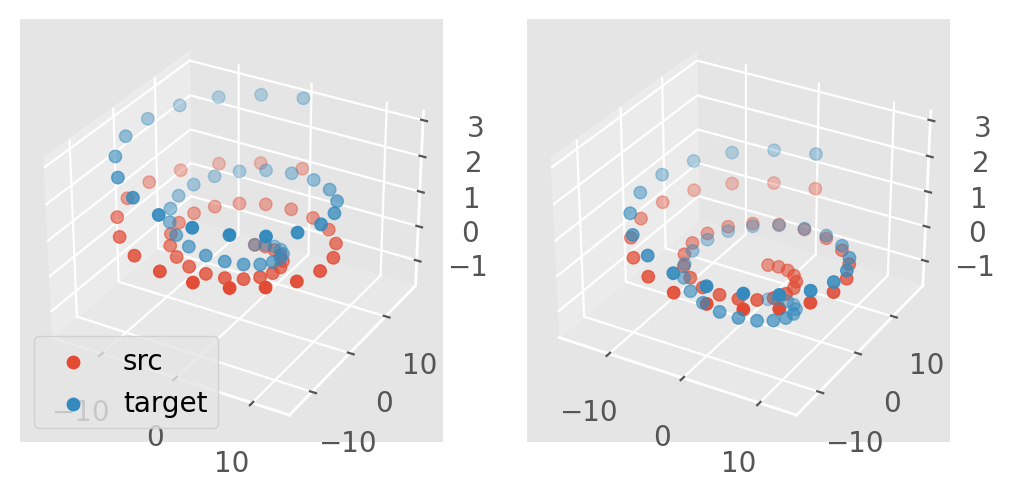

In [4]:
points_tens, target_points_tens = get_src_scaled_spirals()
points, target_points  = to_numpy_array(points_tens),to_numpy_array(target_points_tens)
cent_points, cent_target_points = to_numpy_array(center(points_tens)),to_numpy_array(center(target_points_tens))
_ = viz_point_cloud([(points,'src'),(target_points,'target')],[cent_points,cent_target_points])

## Training

We define the various parameter for the SE3 training

In [23]:
transformer = get_model()
epochs = 15
criterion = RISGW_loss() 
# criterion = hungarian_loss
# criterion = torch.nn.MSELoss()
batch_size = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transformer.to(device)
lr = 0.01
optimizer = torch.optim.Adam(transformer.parameters(),lr=lr)
#optimizer = torch.optim.SGD(transformer.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=100,
                                                       factor=0.4,
                                                       threshold=0.001,
                                                       verbose=True)
centering = True
batch_f = get_src_scaled_spirals
batch_f_kwargs = {}
use_wandb = False

Loading fresh model


In [42]:
run = wandb.init(project='first_trial',reinit=True)

loss,0.02897
_runtime,568
_timestamp,1620808151
_step,100


loss,▇▇▇▇▇▇▇▇▆▅▅▂▃▃▃▃▃▂▁▁▁▁▆█▇▅▄▃▂▂▃▃▂▁▃▃▄▂▄▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [43]:
if use_wanbd:
    config = wandb.config
    config.criterion = criterion
    config.optimizer = optimizer
    config.lr = lr
    config.batch_f = batch_f
    config.batch_f_kwargs = batch_f_kwargs
    config.centering = centering
    wandb.watch(transformer)
    
for epoch in range(epochs):
    train_args = {"model":transformer,
                "use_wandb":use_wandb,
                "optimizer":optimizer,
                "epoch":epoch,
                "criterion":criterion,
                "batch_size":batch_size,
                "scheduler":scheduler,
                "device":device,
                "tb_writer":writer,
                "batch_f":batch_f,
                "batch_f_kwargs":batch_f_kwargs,
                "center_input":centering,
                "center_target":centering,
                "center_output":centering}
    loss = train_one_epoch(**train_args)

Epoch 0


RISGW affine map optimization: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Loss (cntrd prediction vs cntrd target): 39.084571838378906
Epoch 1


RISGW affine map optimization: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Loss (cntrd prediction vs cntrd target): 35.1574592590332
Epoch 2


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Loss (cntrd prediction vs cntrd target): 75.83316040039062
Epoch 3


RISGW affine map optimization: 100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


Loss (cntrd prediction vs cntrd target): 31.011533737182617
Epoch 4


RISGW affine map optimization: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Loss (cntrd prediction vs cntrd target): 38.5942268371582
Epoch 5


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Loss (cntrd prediction vs cntrd target): 34.228153228759766
Epoch 6


RISGW affine map optimization:   0%|          | 0/100 [00:00<?, ?it/s]

Loss (cntrd prediction vs cntrd target): 35.826839447021484
Epoch 7


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Loss (cntrd prediction vs cntrd target): 34.254032135009766
Epoch 8


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Loss (cntrd prediction vs cntrd target): 31.80942153930664
Epoch 9


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Loss (cntrd prediction vs cntrd target): 46.39155197143555
Epoch 10


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Loss (cntrd prediction vs cntrd target): 34.94538879394531
Epoch 11


RISGW affine map optimization:   0%|          | 0/100 [00:00<?, ?it/s]

Loss (cntrd prediction vs cntrd target): 34.64094161987305
Epoch 12


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Loss (cntrd prediction vs cntrd target): 33.849143981933594
Epoch 13


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Loss (cntrd prediction vs cntrd target): 30.75302505493164
Epoch 14


RISGW affine map optimization: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Loss (cntrd prediction vs cntrd target): 35.80839157104492


## Visualize results

In [24]:
fig = visualize_prediction(transformer, batch_f, batch_f_kwargs, centering)
wandb.log({"chart": wandb.Image(fig)})

RuntimeError: shape '[1, 3, 2, 3]' is invalid for input of size 240

In [28]:
dist_pred_target = torch.nn.MSELoss()(predicted_points_tens,target_points_tens_raw)
dist_centtarg_target = torch.nn.MSELoss()(target_points_tens,target_points_tens_raw)
print(dist_pred_target)
print(dist_centtarg_target)

tensor(0.8670, grad_fn=<MseLossBackward>)
tensor(0.7502)


## R1 Overfit plot

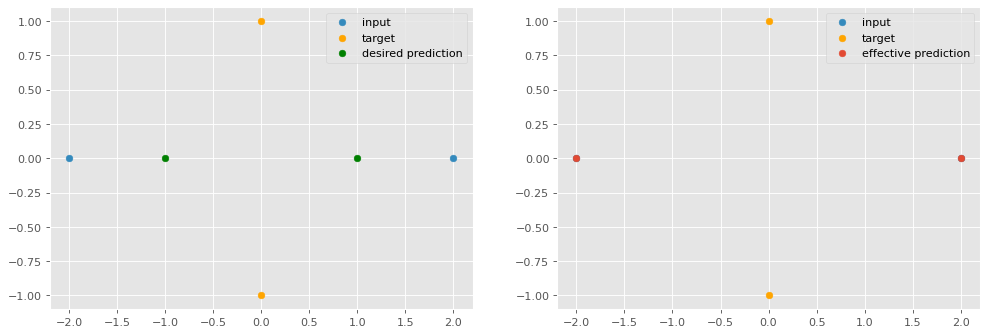

In [29]:
points_tens, target_points_tens = get_r1_src_target() 

predicted_deltas_tens = (predict(transformer,points_tens)
                         .cpu()
                         .reshape(points_tens.shape))
predicted_points_tens = points_tens + predicted_deltas_tens

points = to_numpy_array(points_tens)
target_points = to_numpy_array(target_points_tens)
predicted_points = to_numpy_array(predicted_points_tens)

fig,axes = plt.subplots(1,2,figsize=(15,5))
plot_r1_exp(points,target_points,predicted_points,axes)

## Machine-scale rotation-equivariance error?

In [31]:
# random rotation
Q = rot(*torch.randn(3))
transform = lambda x: x @ Q
scaler = MachineScaleChecker(transform,transformer,N=10)
scaler.get_machine_scale_error()


2.4795703684743486e-14

In [32]:
# 180 degree rotation
Q = torch.eye(3)
Q[0] *= -1
Q[1] *= -1
transform = lambda x: x @ Q
scaler = MachineScaleChecker(transform,transformer,N=10)
scaler.get_machine_scale_error()

2.0028520942433348e-14

In [33]:
 # translation
shift = (torch.rand(1,3) - 0.5) * 1000 * torch.rand(1)
transform = lambda x: x + shift
scaler = MachineScaleChecker(transform,transformer,N=3)
scaler.get_machine_scale_error()

23054.546875

## Visual Check of Translational Invariance

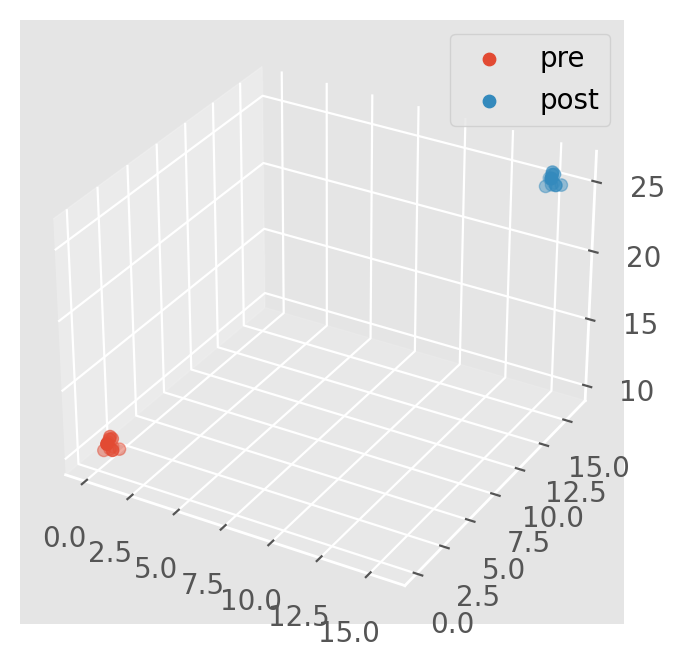

In [34]:
shift = torch.tensor([15,15,15])
points_tens = torch.rand(1,10,3) + torch.tensor([0,0,10])

# we add the shift after the prediction
post_delta_tens = predict(transformer,points_tens)
post_prediction_tens = points_tens + post_delta_tens + shift

# we add the shift before the prediction
pre_delta_tens = predict(transformer,points_tens + shift)
pre_prediction_tens = points_tens + pre_delta_tens
pre_shift, post_shift = to_numpy_array(pre_prediction_tens), to_numpy_array(post_prediction_tens)
viz_point_cloud([(pre_shift,'pre'),(post_shift,'post')])

## Self-interaction term


In [22]:
# transformer --> (...) --> AttentionSE3 --> ConvSE3

## Is the output systematically centered?

In [35]:
N = 25
scale = 1000
shift = 500
rand_points_tens = torch.rand(1,N,3) * scale # we scale the noise
rand_points_tens += torch.tensor([shift,shift,shift]) # and shift the point cloud
predicted_deltas_tens = predict(transformer,rand_points_tens)
print(f"Input barycenter:{rand_points_tens.mean(axis=1)}")
print(f"Output barycenter:{predicted_deltas_tens.mean(axis=1)}")

Input barycenter:tensor([[1008.4020, 1085.2714,  978.3622]])
Output barycenter:tensor([[ 6.5305e-08, -5.3242e-08, -2.1842e-08]], grad_fn=<MeanBackward1>)
